# **So You want a Remote job? Predicting Remote and Flexible Work Arrangements from Developer Survey Data**
**Group: Thimkers**
- Juan Miguel Miranda
- Lance Xavier Lim
---

## **Introduction**
Remote and highly flexible work arrangements have become increasingly coveted among software developers, offering benefits such as improved work-life balance, location flexibility, and expanded employment opportunities even including other countries. However, as remote roles grow more competitive, many job seekers lack clear, data-driven insights into the characteristics commonly associated with such positions.

This project applies supervised machine learning classification techniques to the Stack Overflow 2025 Developer Survey to predict whether a developer works in a remote or highly flexible work arrangement based on demographic, professional, and job-related features. By modeling patterns present in real-world survey data, the study aims to identify factors that are strongly predictive of remote or flexible work status.

---

## **Dataset Description**

**Description**

This project uses data from the Stack Overflow 2025 Developer Survey, a large-scale, annual survey conducted among software developers worldwide. The survey collects self-reported information on demographics, education, employment status, work arrangements, technologies used, and professional experience.

**survey_results_public.csv**

This file contains all of the survey responses, where each row represents a single respondent. Columns correspond to survey questions covering topics such as employment characteristics, work environment, developer role, experience level, education background, and technology usage. Responses include a mix of numerical values, categorical selections, and multi-select answers. This file serves as the main source of data.

**survey_results_schema.csv**

This file provides the metadata and schema for the multiple select questions within the survey.

**Why This Is a Real-World Dataset and Relevant to the Problem**

The Stack Overflow Developer Survey is a real-world dataset collected annually from a large and diverse population of developers. The data reflects self-reported information about respondents' actual employment conditions, work environments, and professional backgrounds, rather than synthetic or simulated data. As a result, the dataset captures real labor market conditions and work arrangements experienced by developers.

The dataset is directly relevant to the problem of predicting remote and flexible work arrangements because it explicitly includes questions about respondents' current work situations, including whether they work remotely, in person, or under flexible arrangements. Additionally, the survey contains a wide range of demographic, professional, and organizational variables. Such as role type, years of experience, education level, company characteristics, and more that can plausibly relate to work arrangement outcomes. 

Because remote work has become increasingly competitive and sought after in the software industry, understanding which characteristics are predictive of remote or highly flexible roles is a socially and professionally relevant task applicable to job seekers and recruiters.

### **Problem Definition and Machine Learning Task**

Can we build a supervised machine learning model that predicts whether a developer is employed in a remote or highly flexible work arrangement based on their professional background, using the Stack Overflow 2025 Developer Survey?

---

# **Data Preparation**

### **Scope and Inclusion**

In this project, the analysis focuses exclusively on respondents' current professional situation as captured by the Stack Overflow 2025 Developer Survey. To ensure that the predictive task reflects present-day employment conditions rather than future intentions or subjective opinions, only variables describing respondents' existing work arrangement, professional background, industry, experience, and current technology usage are considered.

Specifically, the study excludes variables that relate to future interests such as technologies respondents wish to work with in the coming year, as these do not describe their current employment situation. Preference-based and opinion-oriented responses such as personal rankings, preferences, and thoughts regarding AI will be omitted due to their subjective nature and limited relevance to predicting present work situations. Additionally, write-in "Other" custom text fields are excluded in favor of standardized response options provided by the surveyors to maintain consistency and reduce noise.

The feature set is further restricted to general industry and professional characteristics which means that questions related to Stack Overflow community engagement are excluded, as these reflect community interaction rather than employment conditions.

This scoped feature selection allows the model to focus on stable, interpretable characteristics that might plausibly relate to a developer's current work arrangement, while avoiding future-oriented thoughts, subjective preferences, and community-specific behaviors that fall outside the objective of the model.

---

### **Survey Coverage**

To efficiently explore, clean, and prepare the features for modeling, the dataset is processed section by section, following the order and structure of the Stack Overflow 2025 Developer Survey. This approach allows each group of related variables to be examined, cleaned, and transformed independently before being integrated before being used for training. For each section, missing values are identified and handled, categorical variables are standardized and encoded as needed.

The following sections of the survey are included in the analysis:

- **Education + Career**

This section contains variables describing respondents' demographic background and current professional status. Included features capture education level, years of experience, job role, and **current work arrangement**. These variables provide a foundational profile of a developer's career stage and work context.

- **Tech and Tech Culture**

This section includes respondents' current technology usage in professional settings. Variables indicate whether respondents actively worked with programming languages, database systems, web frameworks, and other tools in the past year. Only features reflecting technologies already used are included. Questions describing technologies respondents wish to use in the future or custom write-ins are excluded.

- **AI + AI Agents**

From the AI-related section, only variables describing current AI tool and AI agent usage are included. These features capture whether respondents presently use AI tools and agents as part of their work. Subjective variables such as opinions about AI, trust levels, or frustrations are excluded since they reflect subjective beliefs.

---

In [1]:
# %pip install scikit_posthocs
# %pip install scikit-learn
# %pip install plotly

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

from scipy.stats import pearsonr, spearmanr, levene, f_oneway, shapiro, kruskal, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

survey_data = pd.read_csv('survey_results_public.csv')
survey_schema = pd.read_csv('survey_results_schema.csv') # I don't think this is needed

print(f"Survey data shape: {survey_data.shape}")
print(f"Schema data shape: {survey_schema.shape}")

survey_data.head()

Survey data shape: (49191, 172)
Schema data shape: (139, 6)


C:\Users\Admin\AppData\Local\Temp\ipykernel_95156\120944736.py:22: DtypeWarning: Columns (56,74,92,97,98,105,109,110,132,162,165) have mixed types. Specify dtype option on import or set low_memory=False.
  survey_data = pd.read_csv('survey_results_public.csv')


,ResponseId,MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,...,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,25-34 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,"Caring for dependents (children, elderly, etc.)",8.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,Vertex AI,NaN,NaN,NaN,ChatGPT,NaN,When I don’t trust AI’s answers,"Troubleshooting, profiling, debugging",61256.0,10.0
1,2,I am a developer by profession,25-34 years old,"Associate degree (A.A., A.S., etc.)",Employed,NaN,2.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers;When I want to...,All skills. AI is a flop.,104413.0,9.0
2,3,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Independent contractor, freelancer, or self-em...",None of the above,10.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,ChatGPT;Claude Code;GitHub Copilot;Google Gemini,NaN,When I don’t trust AI’s answers;When I want to...,"Understand how things actually work, problem s...",53061.0,8.0
3,4,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed,None of the above,4.0,"Yes, I am not new to coding but am learning ne...","Other online resources (e.g. standard search, ...","Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,ChatGPT;Claude Code,NaN,When I don’t trust AI’s answers;When I want to...,NaN,36197.0,6.0
4,5,I am a developer by profession,35-44 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...","Caring for dependents (children, elderly, etc.)",21.0,"No, I am not new to coding and did not learn n...",NaN,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers,"critical thinking, the skill to define the tas...",60000.0,7.0


### **Functions Import**

In [2]:
%load_ext autoreload
%autoreload 2
import importlib
import functions
importlib.reload(functions)

funcs = functions.Functions()

### **Checking Duplicates**

None were found

In [3]:
results = funcs.view_duplicates(survey_data)

Duplicate Row Check:
Total rows: 49191
Duplicate rows: 0


In [4]:
funcs.print_unique(survey_data, 'RemoteWork')

All unique responses in 'RemoteWork':
nan: 15411 (31.33%)
Remote: 10931 (22.22%)
Hybrid (some remote, leans heavy to in-person): 6732 (13.69%)
In-person: 6042 (12.28%)
Hybrid (some in-person, leans heavy to flexibility): 5831 (11.85%)
Your choice (very flexible, you can come in when you want or just as needed): 4244 (8.63%)

Total unique responses: 6
Data type: object


### **Creating Target Variable**

The target variable can be found in the RemoteWork column. To define successes and failures, full Remote and Your Choice as both successes. Marking them both as 1 and all else as 0. In future analysis, NA or nan will be considered as not currently employed.

In [5]:
remote_flexible_conditions = [
    'Remote',
    'Your choice (very flexible, you can come in when you want or just as needed)'
]

target = survey_data['RemoteWork'].apply(
    lambda x: 1 if x in remote_flexible_conditions else 0
)

print("Target Variables:")
target_counts = target.value_counts()
total_rows = len(target)

for value, count in target_counts.items():
    percentage = (count / total_rows) * 100
    print(f"{value}: {count} ({percentage:.2f}%)")

Target Variables:
0: 34016 (69.15%)
1: 15175 (30.85%)


### **Education + Career**

**Current Profession**

The original current profession variable (main branch) contains six nominal categories:

- I am a developer by profession
- I am not primarily a developer, but I write code sometimes as part of my work/studies
- I am learning to code
- I code primarily as a hobby
- I used to be a developer by profession, but no longer am
- I work with developers or my work supports developers but am not a developer by profession

To reduce noise and over-fragmentation, these responses were compressed into four groupings that better reflect respondents’ current level of professional involvement. To make it digestible to ML models, the categories were one-hot encoded.

| Compressed Category     | Original Responses                                                                                                                          |
| ----------------------- | ------------------------------------------------------------------------------------------------------------------------------------------- |
| Professional dev    | I am a developer by profession                                                                                                              |
| Non-primary dev     | I am not primarily a developer, but I write code sometimes as part of my work/studies                                                       |
| Learner or hobbyist | I am learning to code; I code primarily as a hobby                                                                                          |
| Retired or non-dev  | I used to be a developer by profession, but no longer am; I work with developers or support developers but am not a developer by profession |



In [6]:
current_profession = survey_data['MainBranch'].apply(funcs.compress_mainbranch)
# Put a prefix on all one-hot encoded columns to make sure none ever get mixed up
current_profession_encoded = pd.get_dummies(current_profession, prefix='profession')

print(f"\nOne-hot encoded features created:")
print(f"Shape: {current_profession_encoded.shape}")
print(f"Columns: {list(current_profession_encoded.columns)}")

current_profession_encoded


One-hot encoded features created:
Shape: (49191, 4)
Columns: ['profession_learner or hobbyist', 'profession_non-primary dev', 'profession_professional dev', 'profession_retired or non-dev']


,profession_learner or hobbyist,profession_non-primary dev,profession_professional dev,profession_retired or non-dev
0,False,False,True,False
1,False,False,True,False
2,False,False,True,False
3,False,False,True,False
4,False,False,True,False
...,...,...,...,...
49186,True,False,False,False
49187,False,False,True,False
49188,False,False,True,False
49189,False,False,True,False


### **Age Group, Highest Education Level, and Employment**

To prepare the categorical variables for machine learning modeling, compression and one-hot encoding was applied to reduce noise and make columns more concise.

**Compression Strategy Overview:**

1. **Current Profession (MainBranch)**: Compressed from 6 original categories to 4 groupings:
- Professional developer
- Non-primary developer (code sometimes)
- Learner or hobbyist
- Retired or non-developer

2. **Education Level**: Compressed from 9 original categories to 8 standardized levels, with NaN values put into to "other":
- bachelor, master, professional, associate
- went to college without degree, secondary school, primary school
- other

3. **Employment Status**: Compressed from 7 original categories to 6 employment status:
- employed, independent, unemployed,  students
- retired, others (includes NaN and "prefer not to say")

In [7]:
# One-hot encode Age groups
age_group = pd.get_dummies(survey_data['Age'], prefix='age_group')

print(f"\nOne-hot encoded age groups:")
print(f"Shape: {age_group.shape}")
print(f"Columns: {list(age_group.columns)}")

# One-hot encode education levels
compressed_education = survey_data['EdLevel'].apply(funcs.compress_education)
education_level = pd.get_dummies(compressed_education, prefix='ed_level')

print(f"\nOne-hot encoded education levels:")
print(f"Shape: {education_level.shape}")
print(f"Columns: {list(education_level.columns)}")

# One-hot encode Employment status
compressed_employment = survey_data['Employment'].apply(funcs.compress_employment)
employment_status = pd.get_dummies(compressed_employment, prefix='employment')

print(f"\nOne-hot encoded employment status:")
print(f"Shape: {employment_status.shape}")
print(f"Columns: {list(employment_status.columns)}")

employment_status


One-hot encoded age groups:
Shape: (49191, 7)
Columns: ['age_group_18-24 years old', 'age_group_25-34 years old', 'age_group_35-44 years old', 'age_group_45-54 years old', 'age_group_55-64 years old', 'age_group_65 years or older', 'age_group_Prefer not to say']

One-hot encoded education levels:
Shape: (49191, 8)
Columns: ['ed_level_associate', 'ed_level_bachelor', 'ed_level_master', 'ed_level_other', 'ed_level_primary school', 'ed_level_professional', 'ed_level_secondary school', 'ed_level_went to college without degree']

One-hot encoded employment status:
Shape: (49191, 6)
Columns: ['employment_employed', 'employment_independent', 'employment_others', 'employment_retired', 'employment_student', 'employment_unemployed']


,employment_employed,employment_independent,employment_others,employment_retired,employment_student,employment_unemployed
0,True,False,False,False,False,False
1,True,False,False,False,False,False
2,False,True,False,False,False,False
3,True,False,False,False,False,False
4,False,True,False,False,False,False
...,...,...,...,...,...,...
49186,True,False,False,False,False,False
49187,True,False,False,False,False,False
49188,True,False,False,False,False,False
49189,False,True,False,False,False,False


### **Developer Type**

The DevType variable originally contained 33 distinct developer roles and specializations. To create more meaningful feature groups, these were compressed into 22 categories to combine smaller groups and create wider yet accurate generalizations.

**Developer Categories:**
- Full-stack, Backend, Frontend, Mobile, Desktop, Embedded, Game, AI/ML developers

**Specialized Roles:**
- Software architects, Data specialists, DevOps/Infrastructure, Database specialists, Security specialists, UX/UI designers

**Other Professional Roles:**
- QA, Managers, Executives/Founders, Researchers/Scientists, Support/Analysts

**Non-Professional:**
- Students, Retired, Others (including NaN and unspecified)

In [8]:
# One-hot encode Developer Type
compressed_devtype = survey_data['DevType'].apply(funcs.compress_devtype)
dev_type_encoded = pd.get_dummies(compressed_devtype, prefix='devtype')

print(f"\nOne-hot encoded developer types:")
print(f"Shape: {dev_type_encoded.shape}")
print(f"Columns: {list(dev_type_encoded.columns)}")

# Show the compression results
print(f"\nCompressed developer type distribution:")
devtype_counts = compressed_devtype.value_counts()
total_rows = len(compressed_devtype)

dev_type_encoded


One-hot encoded developer types:
Shape: (49191, 22)
Columns: ['devtype_ai/ml developer', 'devtype_backend developer', 'devtype_data specialist', 'devtype_database specialist', 'devtype_desktop developer', 'devtype_devops/infrastructure', 'devtype_embedded developer', 'devtype_executive/leader', 'devtype_frontend developer', 'devtype_full-stack developer', 'devtype_game developer', 'devtype_manager', 'devtype_mobile developer', 'devtype_others', 'devtype_qa tester', 'devtype_researcher/scientist', 'devtype_retired', 'devtype_security specialist', 'devtype_software architect', 'devtype_student', 'devtype_support/analyst', 'devtype_ux/ui designer']

Compressed developer type distribution:


,devtype_ai/ml developer,devtype_backend developer,devtype_data specialist,devtype_database specialist,devtype_desktop developer,devtype_devops/infrastructure,devtype_embedded developer,devtype_executive/leader,devtype_frontend developer,devtype_full-stack developer,...,devtype_mobile developer,devtype_others,devtype_qa tester,devtype_researcher/scientist,devtype_retired,devtype_security specialist,devtype_software architect,devtype_student,devtype_support/analyst,devtype_ux/ui designer
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49186,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
49187,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
49188,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
49189,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


### **Years and Experience**

Just a general overview of numerical data. For now its here, maybe move to EDA. 

DONT SCALE YET. DO IT AFTER TEST TRAIN SPLIT

count    42893.000000
mean        13.367403
std         10.800117
min          1.000000
25%          5.000000
50%         10.000000
75%         20.000000
max        100.000000
Name: WorkExp, dtype: float64

count    43042.000000
mean        16.570861
std         11.787610
min          1.000000
25%          8.000000
50%         14.000000
75%         24.000000
max        100.000000
Name: YearsCode, dtype: float64


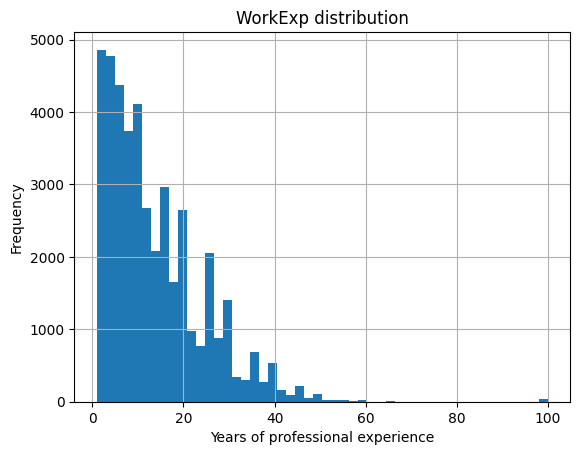

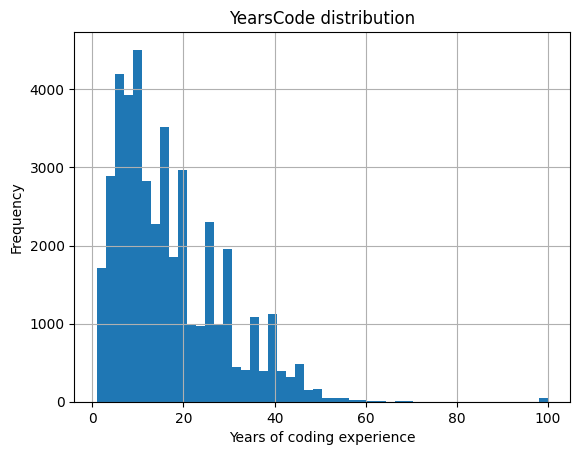

In [9]:
work_years = survey_data["WorkExp"]
learn_years = survey_data["YearsCode"]

work_summary = work_years.describe()
print(work_summary)

print("")

learn_summary = learn_years.describe()
print(learn_summary)

work_years.hist(bins=50)
plt.title("WorkExp distribution")
plt.xlabel("Years of professional experience")
plt.ylabel("Frequency")
plt.show()

learn_years.hist(bins=50)
plt.title("YearsCode distribution")
plt.xlabel("Years of coding experience")
plt.ylabel("Frequency")
plt.show()


### **Organization Size**

The organization size variable contains categories that represent a natural ordering from smallest to largest companies. Unlike the previous categorical variables that are purely nominal.

Because of this, it was assigned and ordered from 0 to 8 to preserve the natural ordering.

In [10]:
org_size_ordinal = survey_data['OrgSize'].apply(funcs.orgsize_ordinal)

print(f"\nOrdinal value distribution:")
ordinal_counts = org_size_ordinal.value_counts().sort_index()
total_rows = len(org_size_ordinal)

for value, count in ordinal_counts.items():
    percentage = (count / total_rows) * 100
    print(f"Value {value}: {count} ({percentage:.2f}%)")



Ordinal value distribution:
Value 0: 15945 (32.41%)
Value 1: 1763 (3.58%)
Value 2: 12288 (24.98%)
Value 3: 6109 (12.42%)
Value 4: 2361 (4.80%)
Value 5: 4156 (8.45%)
Value 6: 1604 (3.26%)
Value 7: 4965 (10.09%)


### **IC or PM**

The ICorPM column contains only two options: Individual Contributor and People Manager. Although, there are numerous missing values in this column so these will be represented as neither.

In [11]:
# One-hot encode IC or PM
compressed_icorpm = survey_data['ICorPM'].apply(funcs.compress_icorpm)
icorpm_encoded = pd.get_dummies(compressed_icorpm, prefix='icorpm')

print(f"\nOne-hot encoded IC or PM types:")
print(f"Shape: {icorpm_encoded.shape}")
print(f"Columns: {list(icorpm_encoded.columns)}")

# Show the compression results
print(f"\nCompressed IC or PM distribution:")
icorpm_counts = compressed_icorpm.value_counts()
total_rows = len(compressed_icorpm)

icorpm_encoded


One-hot encoded IC or PM types:
Shape: (49191, 3)
Columns: ['icorpm_individual contributor', 'icorpm_neither', 'icorpm_people manager']

Compressed IC or PM distribution:


,icorpm_individual contributor,icorpm_neither,icorpm_people manager
0,False,False,True
1,True,False,False
2,False,True,False
3,True,False,False
4,False,True,False
...,...,...,...
49186,False,True,False
49187,False,True,False
49188,False,False,True
49189,False,True,False


### **Industry**

The Industry variable originally contained 24 distinct developer industries (excluding other). Similar industries were combined to create wider yet accurate generalizations. A list of umbrella terms are present below along with their inclusions.

**Fintech:**
- Fintech, Banking/Financial Services, Insurance

**Media and Advertising:**
- Media & Advertising Services, Marketing

**Government:**
- Government and Defense, Legal

**These Remaining Industries Served as their own Features:**
- Software Development, Internet, Telecomm or Information Services, Manufacturing, Higher Education, Retail and Consumer Services, Transportation, or Supply Chain, Computer Systems Design and Services, Energy, Entertainment, Consulting/Professional Services, Aviation/Aerospace, Healthcare & Pharmaceuticals, Non-Profit, Automotive, Real Estate, Agriculture, Human Resources, Environment



In [12]:
# One-hot encode Industry
compressed_industry = survey_data['Industry'].apply(funcs.compress_industry)
industry_encoded = pd.get_dummies(compressed_industry, prefix='industry')

print(f"\nOne-hot encoded Industry types:")
print(f"Shape: {industry_encoded.shape}")
print(f"Columns: {list(industry_encoded.columns)}")
# Show the compression results
print(f"\nCompressed Industry distribution:")
industry_counts = compressed_industry.value_counts()
total_rows = len(compressed_industry)

industry_encoded


One-hot encoded Industry types:
Shape: (49191, 11)
Columns: ['industry_computer systems design', 'industry_energy', 'industry_fintech', 'industry_higher education', 'industry_internet/telecomm/information services', 'industry_manufacturing', 'industry_media and advertising', 'industry_others', 'industry_retail and consumer services', 'industry_software development', 'industry_transportation, or supply chain']

Compressed Industry distribution:


,industry_computer systems design,industry_energy,industry_fintech,industry_higher education,industry_internet/telecomm/information services,industry_manufacturing,industry_media and advertising,industry_others,industry_retail and consumer services,industry_software development,"industry_transportation, or supply chain"
0,False,False,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
49186,False,False,False,False,False,False,False,True,False,False,False
49187,False,False,False,False,False,False,False,True,False,False,False
49188,False,False,True,False,False,False,False,False,False,False,False
49189,False,False,False,False,False,False,False,True,False,False,False
